In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

### Summary

#### 1. Customer have higher chance to terminate the plan when they frequently call to customer service line
#### 2. For customer who keep staying with us are usually don't have international plan and voice mail plan
#### 3. Chrun customer have higher demand of call minutes compare to the staying customer

### Suggestion

#### We can deploy the trained machine learning model found in the jupyter notebook for predicting which customer will be churn and give the following advice to reduce the customer churn rate:

#### 1. Ask if they are still using the international plan or voice mail plan. Help them to terminate it when customer are not willing or actively use it for lowing the customer churn rate
#### 2. Suggest another economical phone plan with more local call minutes and better price

### Read the dataset and perform data cleaning

In [2]:
df = pd.read_csv('customer_data.csv')

In [3]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
# Check any null values
df.isna().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

### We got 3 area code and 51 state coverage in the dataset

In [5]:
# Check the number of unique phone number
df['phone number'].nunique()

3333

In [6]:
df['area code'].unique()

array([415, 408, 510], dtype=int64)

In [7]:
df['state'].nunique()

51

### The top 10 state of the average number of calls to customer service

#### It seems customer have average of 2 calls to customer in different state

In [8]:
df_state = df.groupby('state')['customer service calls'].mean().reset_index()

df_state.sort_values(by='customer service calls', ascending=False).nlargest(10, 'customer service calls')

,state,customer service calls
2,AR,1.981818
10,GA,1.925926
5,CO,1.787879
36,OK,1.786885
21,ME,1.741935
46,VT,1.739726
37,OR,1.730769
17,KY,1.711864
34,NY,1.710843
20,MD,1.700000


#### Customers who leave us usually have higher number of calls to customer service before their termination

Text(0.5, 1.0, 'Average number of service calls by churn')

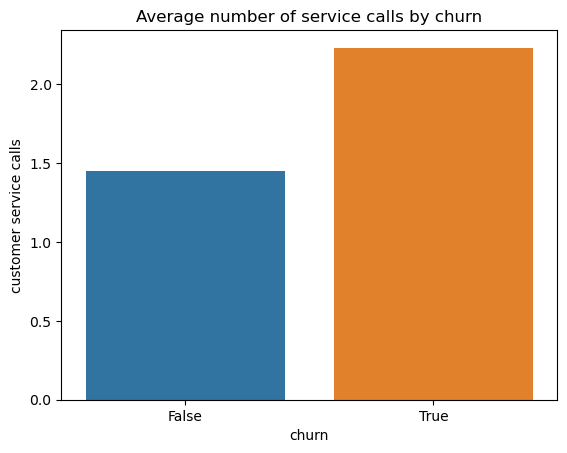

In [9]:
df_calls = df.groupby('churn')['customer service calls'].mean().reset_index()

sns.barplot(x='churn', y='customer service calls', data=df_calls)
plt.title('Average number of service calls by churn')

### Area 415 have higher number of the customers compare to other district

<Axes: xlabel='area code', ylabel='phone number'>

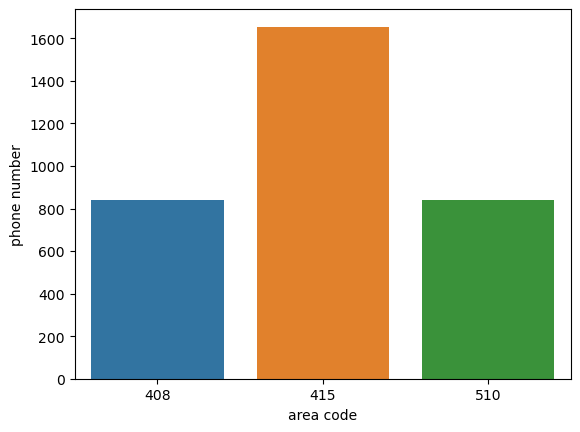

In [10]:
df_code = df.groupby('area code')['phone number'].count().reset_index()

sns.barplot(x='area code', y='phone number', data=df_code)

### Majority of phone number don't have extra service on their phone plan

<Axes: xlabel='international plan', ylabel='phone number'>

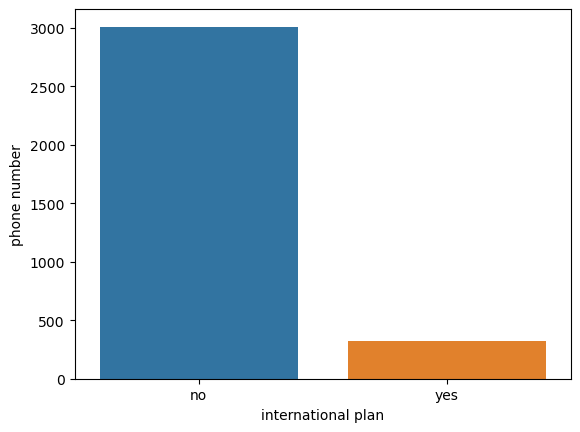

In [11]:
df_intl = df.groupby('international plan')['phone number'].count().reset_index()

sns.barplot(x='international plan', y='phone number', data=df_intl)

Text(0.5, 1.0, 'customers with voice mail plan')

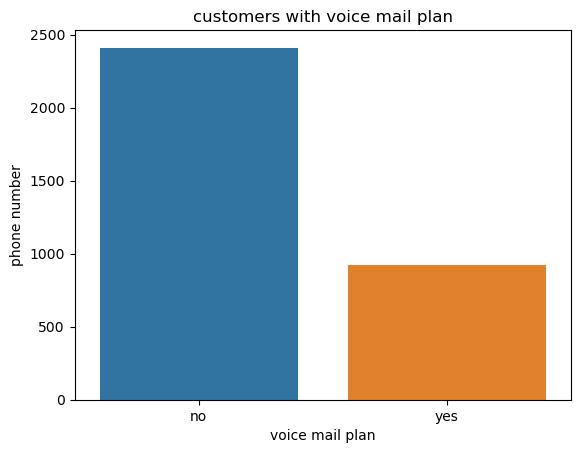

In [12]:
df_voice = df.groupby('voice mail plan')['phone number'].count().reset_index()


sns.barplot(x='voice mail plan', y='phone number', data=df_voice)
plt.title('customers with voice mail plan')

### Churn customer are concern about the call minutes in each day of section

In [13]:
column_list = df.columns.to_list()
total_list = []

# check the substring is match for each list element
for s in column_list:
    if 'total' in s:
        total_list.append(s)

# Convert the list into a dictionary with values
total_dictionary = {value: 'mean' for key, value in enumerate(total_list)}

In [14]:
# Aggregate to mean for each totals
df_churn_total = df.groupby('churn').agg(total_dictionary).reset_index()

# unpivot the table for ploting
unpivoted_churn_total = df_churn_total.melt(id_vars='churn', var_name='total_category', value_name='total')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'total day minutes'),
  Text(1, 0, 'total day calls'),
  Text(2, 0, 'total day charge'),
  Text(3, 0, 'total eve minutes'),
  Text(4, 0, 'total eve calls'),
  Text(5, 0, 'total eve charge'),
  Text(6, 0, 'total night minutes'),
  Text(7, 0, 'total night calls'),
  Text(8, 0, 'total night charge'),
  Text(9, 0, 'total intl minutes'),
  Text(10, 0, 'total intl calls'),
  Text(11, 0, 'total intl charge')])

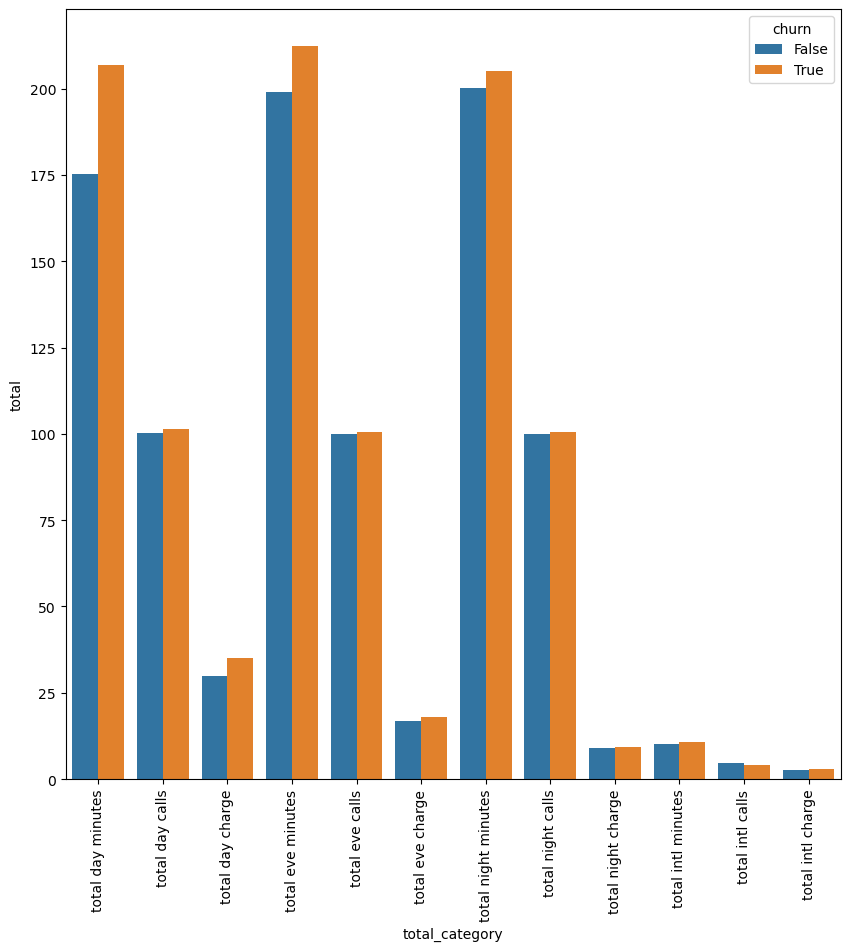

In [15]:
plt.figure(figsize=(10, 10))
sns.barplot(x='total_category', y='total', hue='churn', data=unpivoted_churn_total)
plt.xticks(rotation=90)

### data cleaning

In [16]:
# one hot encoding the area code for model training
df_encoded = pd.get_dummies(df['area code']).astype(int)
df_encoded = df_encoded.add_prefix('area_')

In [17]:
# get dummies for categorical column and concat to the original df
def column_dummies(df, column):
    df_encoded = pd.get_dummies(df[column]).astype(int)
    df_encoded = df_encoded.add_prefix(column + '_')
    df = pd.concat([df, df_encoded], axis = 1)
    df = df.drop(columns=column, axis = 1)
    return df

In [18]:
column_dummies(df, 'area code')

,state,account length,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,...,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,area code_408,area code_415,area code_510
0,KS,128,382-4657,no,yes,25,265.1,110,45.07,197.4,...,91,11.01,10.0,3,2.70,1,False,0,1,0
1,OH,107,371-7191,no,yes,26,161.6,123,27.47,195.5,...,103,11.45,13.7,3,3.70,1,False,0,1,0
2,NJ,137,358-1921,no,no,0,243.4,114,41.38,121.2,...,104,7.32,12.2,5,3.29,0,False,0,1,0
3,OH,84,375-9999,yes,no,0,299.4,71,50.90,61.9,...,89,8.86,6.6,7,1.78,2,False,1,0,0
4,OK,75,330-6626,yes,no,0,166.7,113,28.34,148.3,...,121,8.41,10.1,3,2.73,3,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,414-4276,no,yes,36,156.2,77,26.55,215.5,...,83,12.56,9.9,6,2.67,2,False,0,1,0
3329,WV,68,370-3271,no,no,0,231.1,57,39.29,153.4,...,123,8.61,9.6,4,2.59,3,False,0,1,0
3330,RI,28,328-8230,no,no,0,180.8,109,30.74,288.8,...,91,8.64,14.1,6,3.81,2,False,0,0,1
3331,CT,184,364-6381,yes,no,0,213.8,105,36.35,159.6,...,137,6.26,5.0,10,1.35,2,False,0,0,1


In [19]:
# function to convert yes/no to 1/0
def string_to_integer(df, column):
    map_dict = {'yes': 1, 'no': 0}
    df[column] = df[column].map(map_dict)

In [20]:
# List of columns to convert
to_integer_column_list = ['international plan', 'voice mail plan']

# loop through list to run the function
for item in to_integer_column_list:
    string_to_integer(df, item)

In [21]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [22]:
# calculate total local call minutes, calls and charge
df['local minutes'] = df['total day minutes'] + df['total eve minutes'] + df['total night minutes']
df['local calls'] = df['total day calls'] + df['total eve calls'] + df['total night calls']
df['local charge'] = df['total day charge'] + df['total eve charge'] + df['total night charge']

In [23]:
# Drop the unnecessary columns
df.drop(columns=['state','area code','phone number'], axis=1, inplace=True)

### Customer whether have the international plan and their total day minutes and day charge are the major correlated factor of the customer churn rate
### Customer who have more call to customer service also correlated to the churn rate

<Axes: >

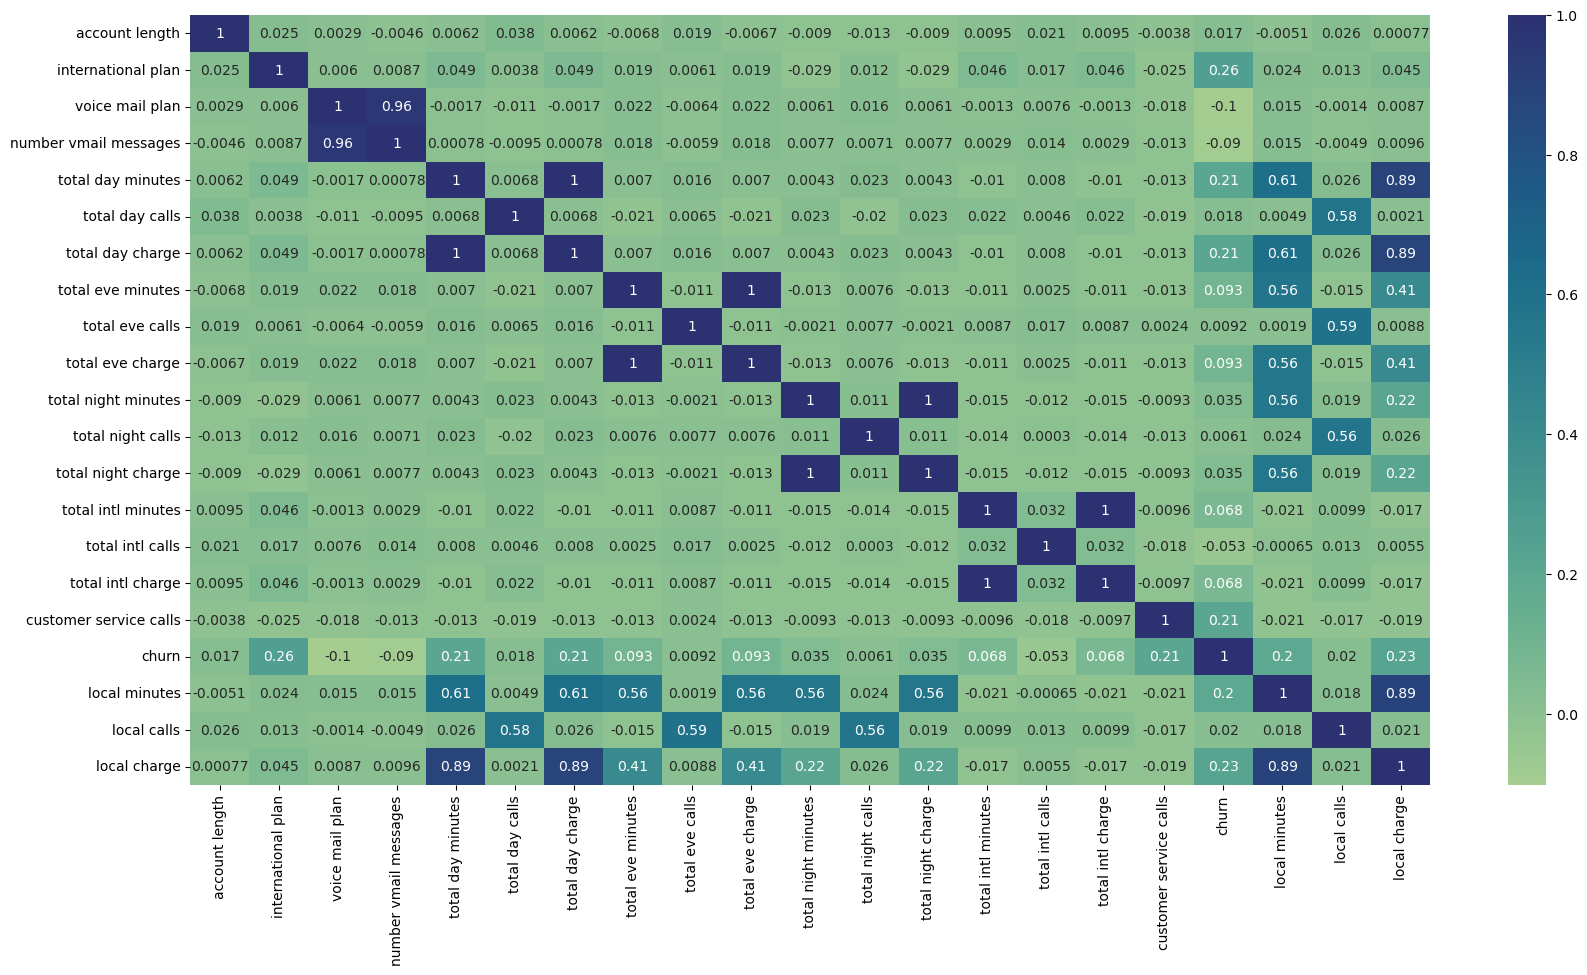

In [24]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), cmap='crest', annot=True)


### Train the prediction model using xgboost and gridsearchCV to find the best parameter

In [25]:
xgb_model = XGBClassifier()

In [26]:
# Set up parameters
parameters = {
    'max_depth':[3, 4, 5],
    'learning_rate':[0.1, 0.2, 0.3],
    'n_estimators':[100, 200, 300]
}

# Split the data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='churn', axis=1), df['churn'], test_size=0.2)

# Finding the best parameters for training the model
clf = GridSearchCV(xgb_model, parameters, cv=5, scoring='f1')

In [29]:
# Train the model
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [30]:
# Predict the test dataset
y_predict = clf.predict(X_test)

In [31]:
# Review the accuracy of the model
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98       577
        True       0.99      0.77      0.86        90

    accuracy                           0.97       667
   macro avg       0.98      0.88      0.92       667
weighted avg       0.97      0.97      0.97       667



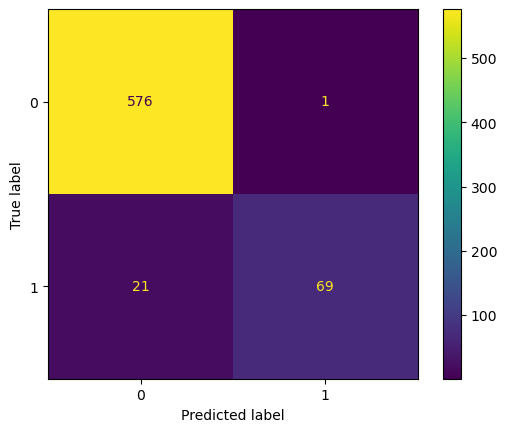

In [39]:
# Confusion martix to see the performance
cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_display.plot()

In [32]:
# retrieve the best estimator model and its feature importance
best_model = clf.best_estimator_
best_features = best_model.feature_importances_

### The presence of voice mail plan and the local charge affect the customer churn rate most 

<Axes: xlabel='feature_importance', ylabel='column'>

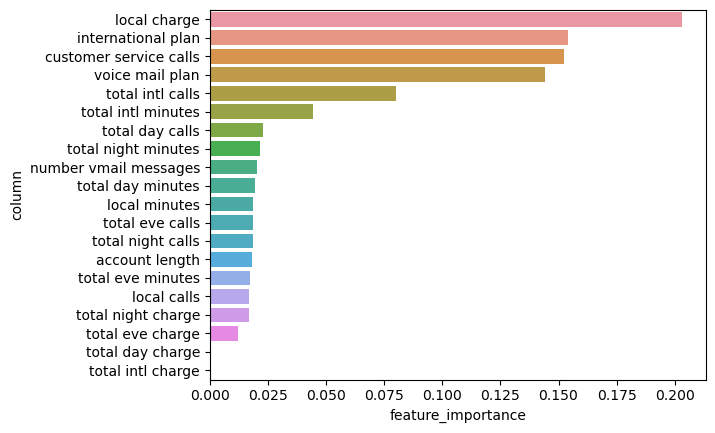

In [33]:
column_names = list(X_train.columns)
feature_importance = list(best_features)
df_feature_importance = pd.DataFrame({'column': column_names, 'feature_importance': feature_importance})

sns.barplot(x='feature_importance', y='column', data=df_feature_importance.sort_values(by='feature_importance', ascending=False))